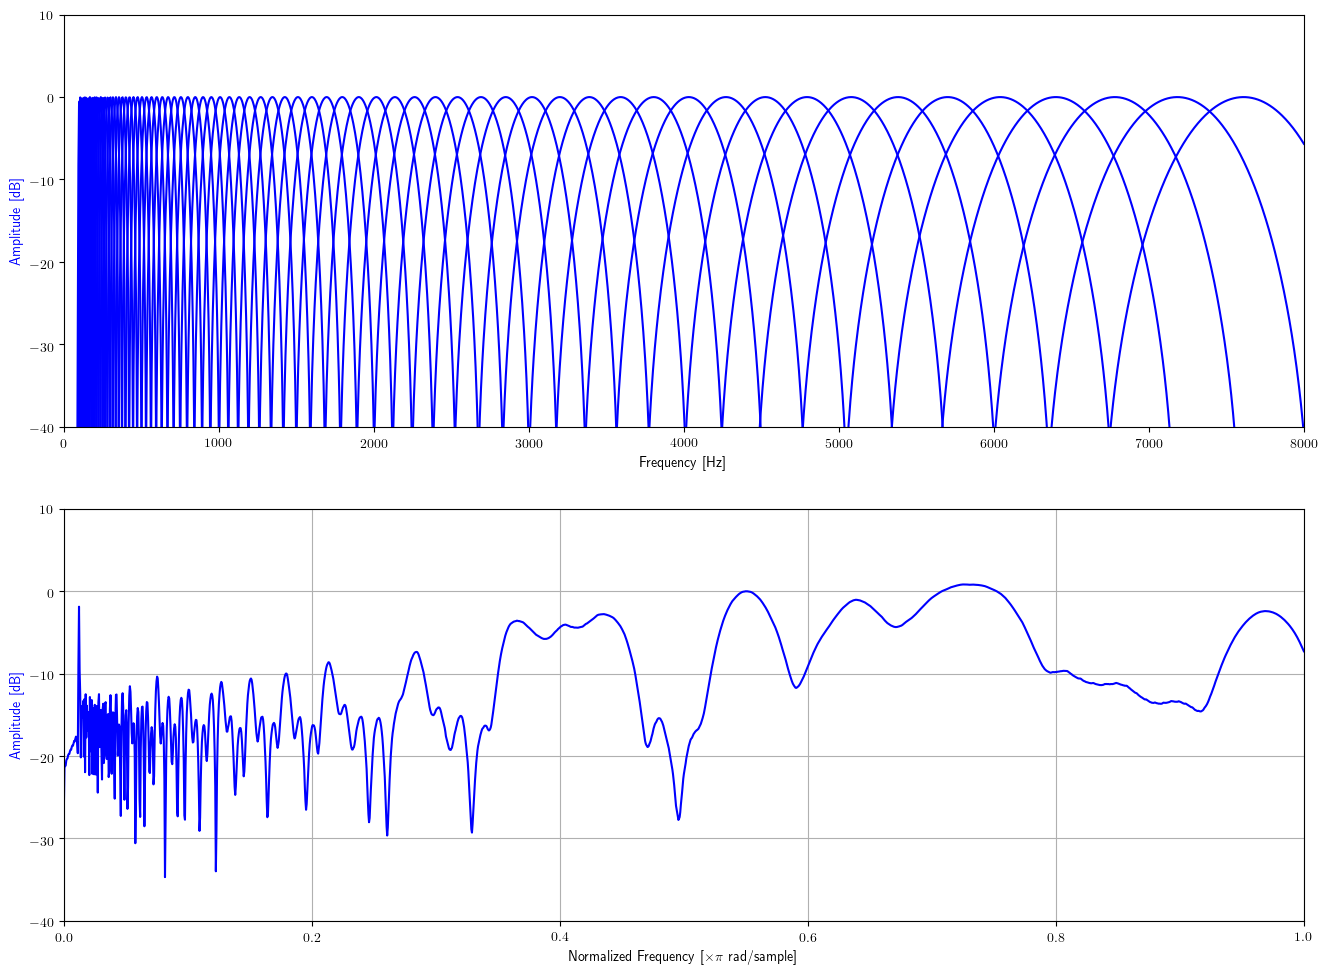

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import fft, rfft, ifft
from audlib.sig.fbanks import ConstantQ
from audlib.plot import magresp
plt.rc('text', usetex=True)

sr = 16000
nfft = 2**12
nyquist = nfft//2+1  # Boundary for Nyquist frequency
nbins_per_octave = 12
fmin = 100
cqbank = ConstantQ(sr, fmin, bins_per_octave=nbins_per_octave)

### Plot filter responses
fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = fig.add_subplot(211)

total = np.zeros((nyquist), dtype=np.complex_)
for kk in range(len(cqbank)):
    ww, hh = cqbank.freqz(kk, nfft=nfft)
    total += hh[:nyquist]
    magresp(ww[:nyquist]/np.pi*(sr/2), hh[:nyquist], ax1, units=('hz', 'db'))
#ax1.set_xscale('log')

# Plot total filter response
ax2 = fig.add_subplot(212)
magresp(ww[:nyquist]/np.pi, total, ax2, units=('rad', 'db'))
#ax2.set_xscale('log')

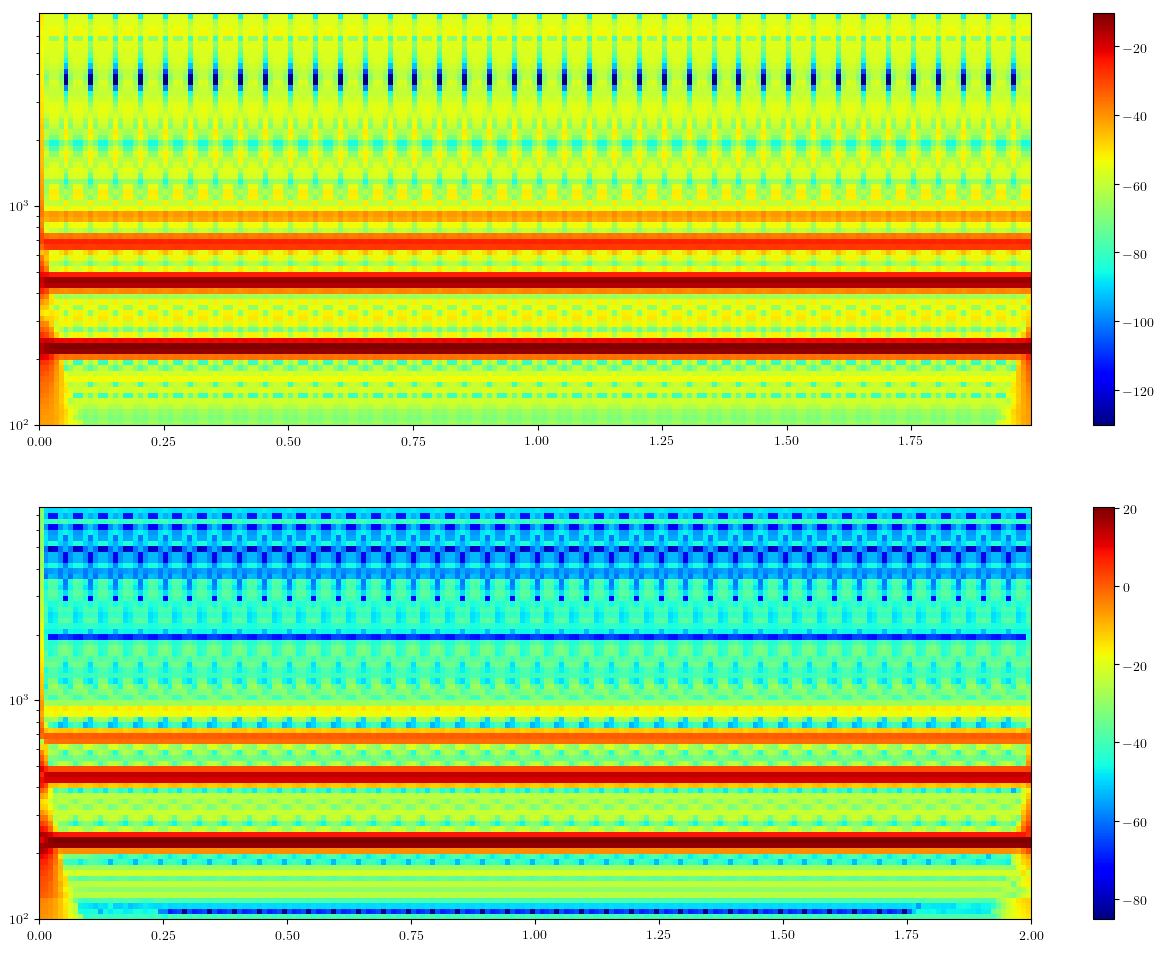

In [2]:
import librosa
from scipy.signal import chirp
from audlib.quickstart import welcome
from audlib.plot import specgram

DEMO = 'FM'  # speech or chirp

if DEMO == 'speech':
    sig, sr = welcome()
elif DEMO == 'chirp':  # make 2 seconds of a chirp signal
    sr = 16000
    sig = chirp(np.arange(0,2, 1/sr), 100, 2, 6000, method='log')
elif DEMO == 'FM':
    sr = 16000
    fc = 220
    fm = 220
    beta = 1
    tt = np.arange(0,2,1/sr)
    sig = np.sin(2*np.pi*fc*tt + beta*np.sin(2*np.pi*fm*tt))

frate = 100

cqt_sig =  cqbank.cqt(sig, frate)
fig = plt.figure(figsize=(16, 12), dpi= 100)
ax = fig.add_subplot(211)
specgram(20*np.log10(np.abs(cqt_sig)), ax, time_axis=np.arange(cqt_sig.shape[0])*(1/frate), freq_axis=cqbank.cfs)
ax.set_yscale('log')
# Compare with librosa
cqt_librosa = librosa.core.cqt(sig, sr=sr, hop_length=int(sr/frate), fmin=100, n_bins=76, window='hamming').T
ax = fig.add_subplot(212)
specgram(20*np.log10(np.abs(cqt_librosa)), ax, time_axis=np.arange(cqt_librosa.shape[0])*(1/frate), freq_axis=cqbank.cfs)
ax.set_yscale('log')

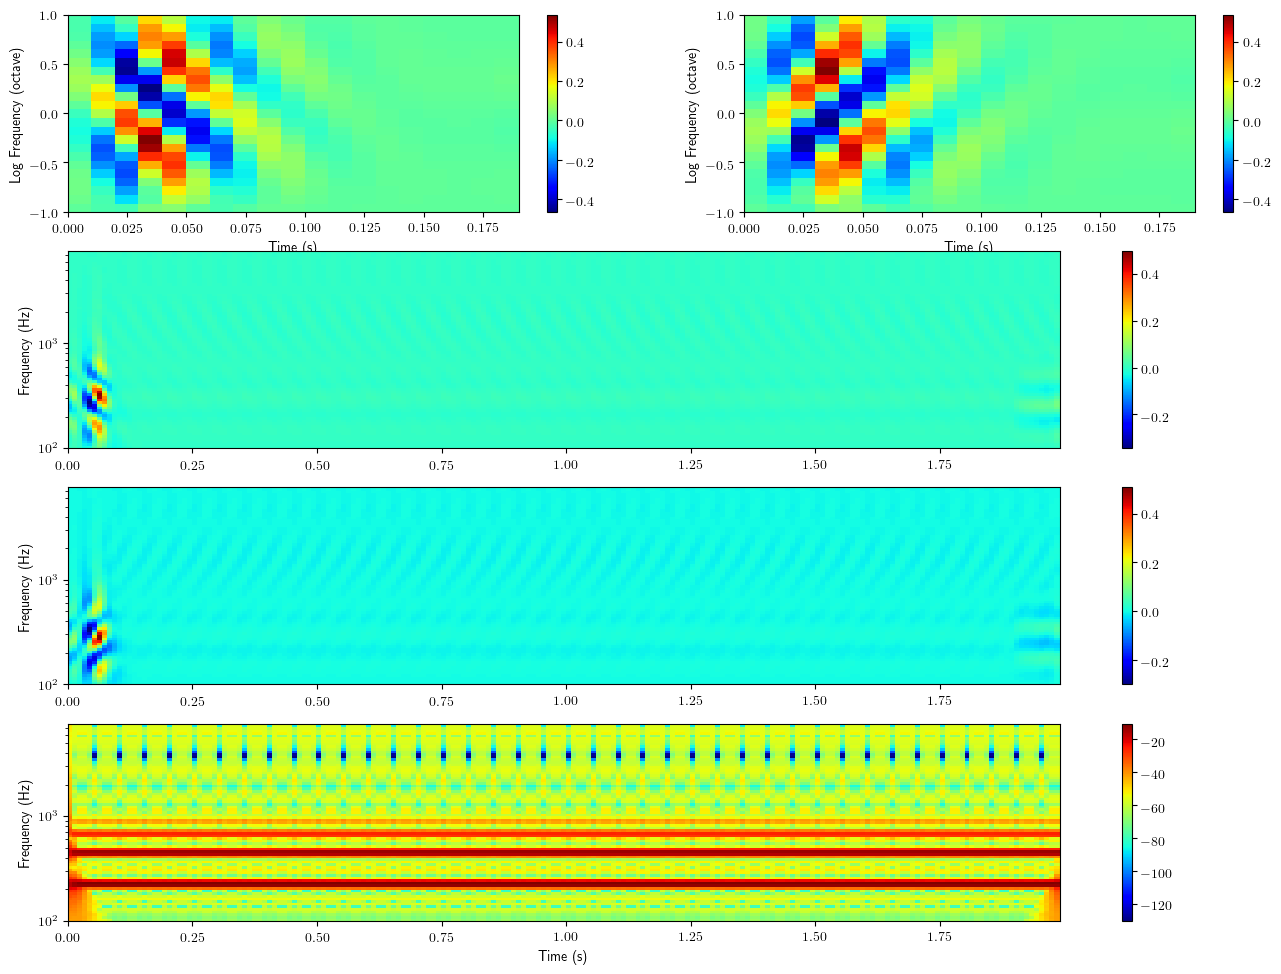

In [3]:
# Build STRF kernels for visualizing
from audlib.sig.spectemp import strf
from scipy.signal import correlate2d

time_support = .2
freq_support = 1
kdn, kup = strf(time_support, freq_support, frate, nbins_per_octave, rate=20, scale=.5)

respdn = correlate2d(np.abs(cqt_sig), kdn, mode='same')
respup = correlate2d(np.abs(cqt_sig), kup, mode='same')
fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = plt.subplot2grid((4, 2), (0, 0))
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
ax4 = plt.subplot2grid((4, 2), (2, 0), colspan=2)
ax5 = plt.subplot2grid((4, 2), (3, 0), colspan=2)
specgram(kdn, ax1, time_axis=np.arange(kdn.shape[0])*(1/frate),
         freq_axis=np.linspace(-freq_support, freq_support, num=kdn.shape[1]))
ax1.set_xlabel('Time (s)'); ax1.set_ylabel('Log Frequency (octave)')
specgram(kup, ax2, time_axis=np.arange(kup.shape[0])*(1/frate),
         freq_axis=np.linspace(-freq_support, freq_support, num=kup.shape[1]))
ax2.set_xlabel('Time (s)'); ax2.set_ylabel('Log Frequency (octave)')
specgram(respdn, ax3, time_axis=np.arange(cqt_sig.shape[0])*(1/frate), freq_axis=cqbank.cfs)
ax3.set_ylabel('Frequency (Hz)')
ax3.set_yscale('log')
specgram(respup, ax4, time_axis=np.arange(cqt_sig.shape[0])*(1/frate), freq_axis=cqbank.cfs)
ax4.set_ylabel('Frequency (Hz)')
ax4.set_yscale('log')
specgram(20*np.log10(np.abs(cqt_sig)), ax5, time_axis=np.arange(cqt_sig.shape[0])*(1/frate), freq_axis=cqbank.cfs)
ax5.set_xlabel('Time (s)'); ax5.set_ylabel('Frequency (Hz)')
ax5.set_yscale('log')